# Relevant imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from scipy.signal import argrelextrema
import math
import numpy as np
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.legend_handler import HandlerBase
import matplotlib.pyplot as plt
import sys
import os,glob
import yaml
from scipy.special import gamma
from scipy.optimize import fsolve
from scipy.interpolate import interp1d  
import pandas as pd
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size']=13
plt.rcParams['text.usetex']=True
plt.rcParams['font.family']='stix'
plt.rcParams['figure.figsize']= (6.5,4)
plt.rcParams['figure.dpi']=150
plt.rcParams['axes.facecolor'] = 'white'

---

In [2]:
class VDS0():  

############################# INITIALIZATION #############################
    
    def __init__(self, h = 0.6727, Omega_m = 0.26495, Omega_b = 0.05, Omega_rad = 10e-5, p_crit = 4.755e-6,
                 rho_crit = 4.755e-6, T0 = 2.7255, kb = 8.617333262145e-5, m_p = 0.93827231, nu = 1.12,
                 Y_p = 0.75, n_e = 0.18820, x_e = 1.16371, sigmaT = 6.65246e-29, c = 3e5, Mpc2cm = 3.086e24, 
                 masses = np.array([1e-4,1e-3,1e-2,1e-1,1.,10.]), 
                 sigma_array = np.logspace(-10,-40,200)):
        
        self.h = h
        self.H0 = 100*h
        self.Omega_m = Omega_m
        self.Omega_b = Omega_b
        self.Omega_rad = Omega_rad
        self.Y_p = Y_p
        self.m_p = m_p
        self.nu = nu
        self.n_e = n_e
        self.x_e = x_e
        self.sigmaT = sigmaT
        self.rho_crit = 1.256*10**11*Omega_m
        self.rho_b = Omega_b*p_crit
        self.T_0 = kb*T0*1e-9
        self.Mpc2m = Mpc2cm*1e-2
        self.Rx_conerverionFactor = c*Mpc2cm
        
        self.masses = masses
        self.sigma_array = sigma_array

        
############################# INI GENERATION #############################

    def make_inis(self,
                  ini_base_file='class/inis/dmeff_base.ini',
                  base_inis_path='class/inis/',
                  class_runner_path = 'class/',
                  sh_file='class/run_classes.sh',
                  output_path='pk_output',
                  npow=0,
                  masses=np.array([1e-4,1e-3,1e-2,1e-1,1.,10.]),
                  sigmas=np.logspace(-20,-30,100)):
    
        fin =  open(ini_base_file, 'r')
        base_content = fin.read()
        fin.close()
        fout_sh = open(class_runner_path+'run_classes.sh', 'w')

        for m in masses:
            for sigma in sigmas:
                filename = 'n{}_m{}_s{}.ini'.format(npow,m,sigma)
                fout_sh.write('./class ' + 'inis/{}\n'.format(filename))
                fout = open(base_inis_path + filename, 'w')
                fout.write(base_content)
                fout.write('\n')
                npow_line = 'npow_dmeff = {}\n'.format(npow)
                fout.write(npow_line)
                m_line = 'm_dmeff = {}\n'.format(m)
                fout.write(m_line)
                sigma_line = 'sigma_dmeff = {}\n'.format(sigma)
                fout.write(sigma_line)
                if npow<0:
                    vel_line = 'Vrel_dmeff_rate = 30\n' #sets to DBK case.
                    fout.write(vel_line)
                root_line = 'root = {}/n{}_m{}_s{}_\n'.format(output_path,npow,m,sigma)
                fout.write(root_line)

        fout_sh.close()

############################# TK PLOTTING FUNCTIONS #############################
        
    def single_tk(self,npow=0,m=0.0001,plotPeaks=False,pltType='none',
                  index=0,sigmas=np.logspace(-20,-30,100),lw=2.5,label='',
                  c='k',ls='-',alpha=1,
                  class_runner_path='dmeff-satellite-limits/class/'):

        data0 = np.loadtxt(class_runner_path+'pk_output/lcdm_z1_pk.dat')
        ks = data0[:,0]
        pk0 = data0[:,1]

        for i,sigma in enumerate(sigmas):
            # Index of interest
            if i!=index:
                continue
            print(sigma)
            
            # pk data from class for given mass, sigma, power
            filename = class_runner_path+'pk_output/n{}_m{}_s{}_z1_pk.dat'.format(npow,m,sigma)
            np.loadtxt(filename)
            data = np.loadtxt(filename)
            pk = data[:,1]
            
            ax.plot(ks,(pk)/pk0,linewidth=lw,linestyle=ls,color=c,label=label,alpha=alpha)

        return (pk)/pk0,ks,sigma

In [3]:
vds0 = VDS0()

---

# Limits

In [90]:
masses_test = [1e-4,1e-3,1e-2,1e-1,1.,10.]
smallSigs = np.logspace(-20,-30,100)
smallSigs2 = np.logspace(-17,-30,100)
largeSigs = np.logspace(-10,-30,100)
sigma1 = 1e-20
sigma2 = sigma1/4
npow_ = 4

In [7]:
# Boddy version of CLASS
vds0.make_inis(ini_base_file='KBoddy/class_public-dmeff/inis/dmeff_base.ini',
               base_inis_path='KBoddy/class_public-dmeff/inis/',
               class_runner_path = 'KBoddy/class_public-dmeff/',
               sh_file='KBoddy/class_public-dmeff/run_classes.sh',
               output_path='pk_output_n0',
               npow=0,
               masses=[1e-5,0.0001,0.001,0.01,0.1,1,10,100],
               sigmas=np.logspace(-26,-30,20))

In [92]:
# Gluscevic version of CLASS
vds0.make_inis(ini_base_file='dmeff-satellite-limits/class/inis/dmeff_base.ini',
               base_inis_path='dmeff-satellite-limits/class/inis/',
               class_runner_path = 'dmeff-satellite-limits/class/',
               sh_file='dmeff-satellite-limits/class/run_classes.sh',
               output_path='pk_output',
               npow=npow_,
               masses=[1e-4],
               sigmas=[sigma1,sigma2])

---

# Transfer function business

Gluscevic
2.5e-21

Boddy
1e-20


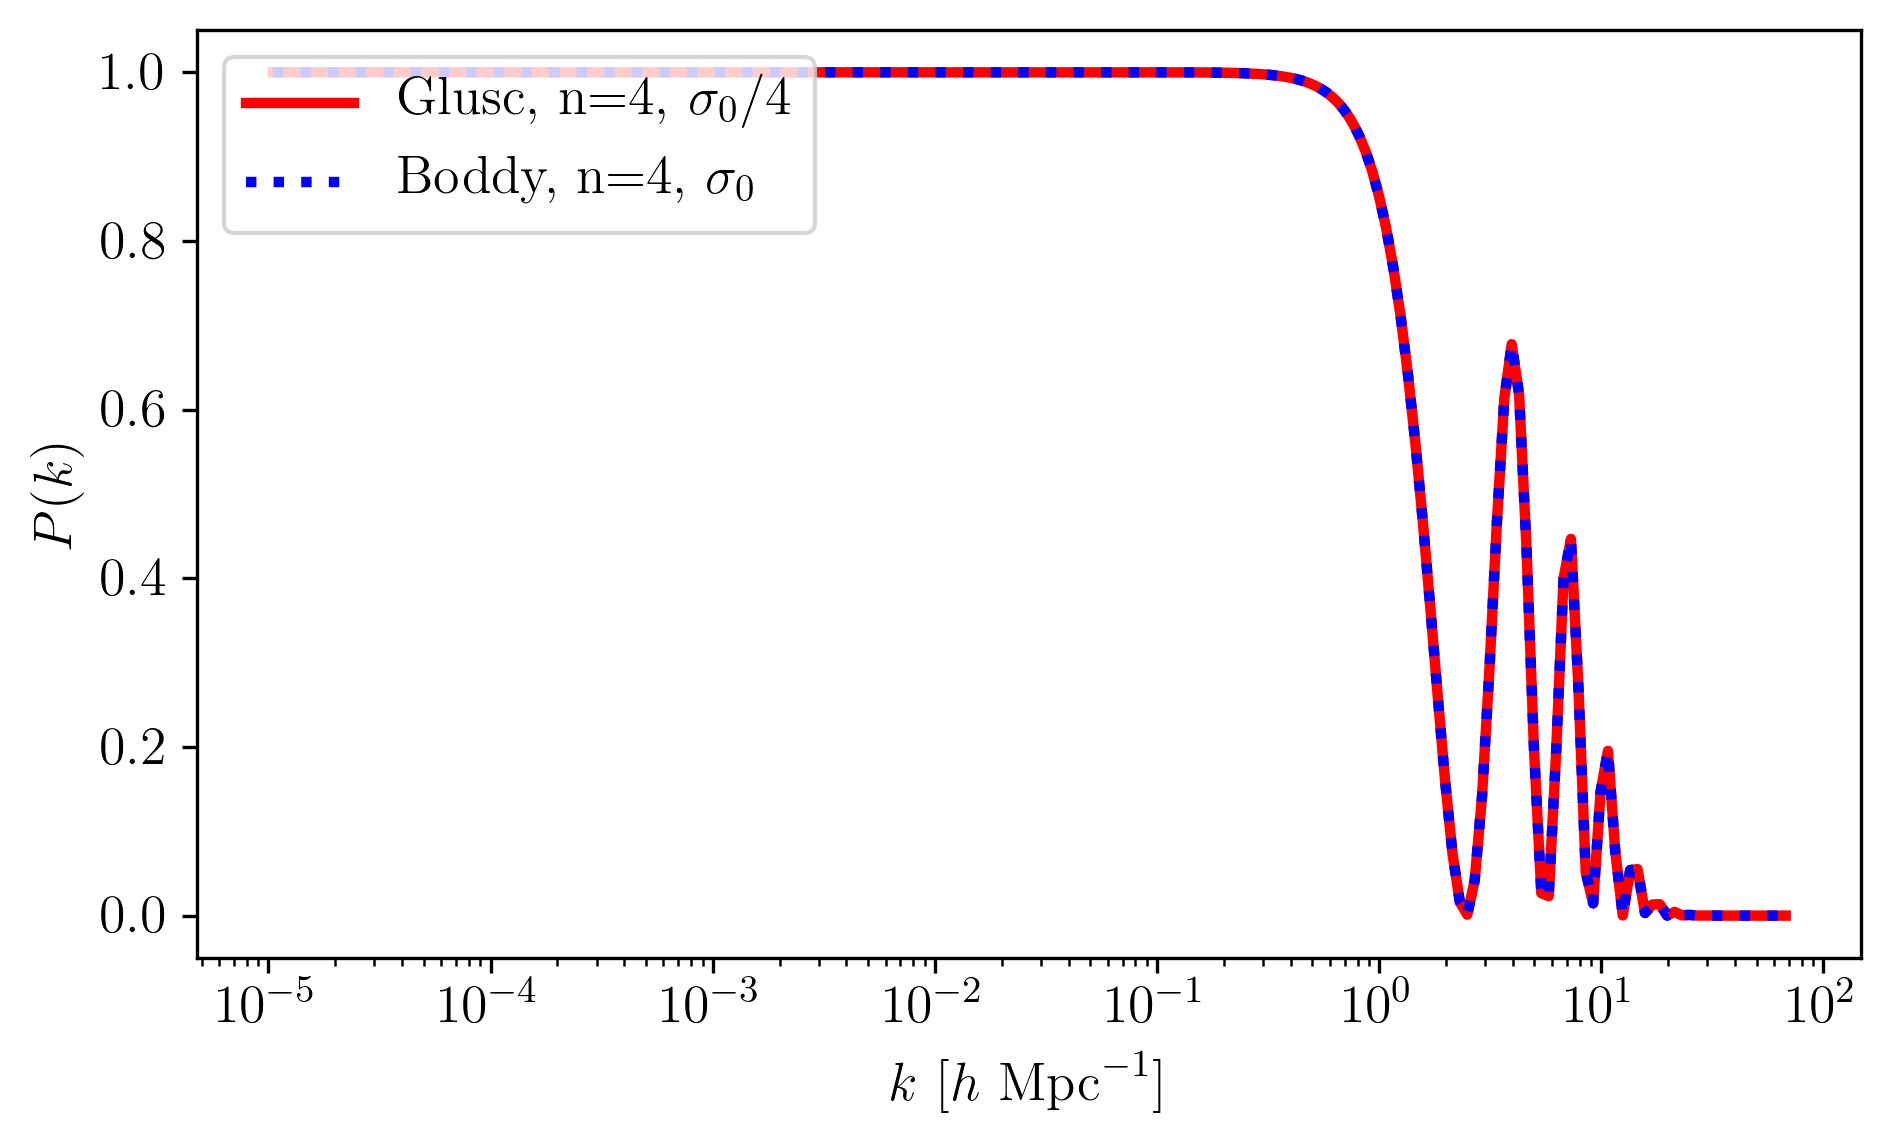

In [94]:
fig = plt.figure()    
ax = fig.add_subplot(111)

# From Gluscevic CLASS version
print("Gluscevic")
tk_idm_G,ks_G,sigma0_G = vds0.single_tk(class_runner_path='dmeff-satellite-limits/class/',
                                        npow=npow_,m=0.0001,sigmas=[sigma1,sigma2],index=1,
                                        c='r',ls='-',label="Glusc, n={}, $\sigma_0/4$".format(npow_))

# From Kim CLASS version
print("\nBoddy")
tk_idm_K,ks_K,sigma0_K = vds0.single_tk(class_runner_path='KBoddy/class_public-dmeff/',
                                        npow=npow_,m=0.0001,sigmas=[sigma1],index=0,
                                        c='b',ls=':',label="Boddy, n={}, $\sigma_0$".format(npow_))

# From Ethan, load from data file
# print("\nNadler\n1e-26")
# data0 = np.loadtxt('DMBaryonScattering/data/pk_output/lcdm_z1_pk.dat')
# ks_E = data0[:,0]
# pk0_E = data0[:,1]
# filename = 'DMBaryonScattering/data/pk_output/n0_m0.0001_s1e-26_z1_pk.dat'
# np.loadtxt(filename)
# data = np.loadtxt(filename)
# pk_E = data[:,1]
# tk_E = pk_E/pk0_E

# ax.plot(ks_E,tk_E,lw=5,label="Nadler")
# ax.plot(ks_G,(tk_idm_G-tk_idm_K)/tk_idm_G,ls='--',label="Gluscevic-Boddy/Gluscevic")
# ax.plot(ks_G,tk_idm_G,ls='--',label="Gluscevic")
# ax.plot(ks_K,tk_idm_K,ls=':',label="Boddy")

ax.set_xscale('log')
ax.set_xlabel(r'$k$ [$h\ \rm{Mpc}^{-1}$]')
ax.set_ylabel(r'$P(k)$')
ax.legend(loc='upper left')

plt.tight_layout()